# __Проект: Обучение с учителем: качество модели.__

**Задача**:  построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца, и, используя данные модели и данные о прибыльности клиентов, выделить сегменты покупателей и разработать для них персонализированные предложения. 


**Данные** состоят из четырёх таблиц, в которых содержится информация о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении, о выручке, которую получает магазин с покупателя,о времени, которое покупатель провёл на сайте в течение периода и о среднемесячной прибыли покупателя за последние 3 месяца.

#### Импортируем необходимые библиотеки.

In [1]:
!pip install -q --upgrade scikit-learn
!pip install -q --upgrade matplotlib
!pip install -q --upgrade seaborn
!pip install -q --upgrade numpy
!pip install -q --upgrade numba

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.


In [2]:
!pip install phik
!pip install shap

  Using cached numpy-1.24.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import shap
import phik
from phik import phik_matrix

from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.model_selection import (train_test_split,
                                    GridSearchCV,
                                    RandomizedSearchCV)
from sklearn.preprocessing import (OneHotEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                  LabelEncoder,
                                  OrdinalEncoder)
from sklearn.metrics import (r2_score,
                             roc_auc_score,
                             mean_absolute_error,
                             mean_squared_error,
                             accuracy_score,
                            confusion_matrix,
                            recall_score,
                            precision_score)

from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


## Шаг. Загрузка данных

In [4]:
try:
    market_file = pd.read_csv('/datasets/market_file.csv')
    market_money = pd.read_csv('/datasets/market_money.csv')
    market_time = pd.read_csv('/datasets/market_time.csv')
    money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
except:
    try:
        market_file = pd.read_csv('C:/Users/1/Documents/DS 2024///datasets/market_file.csv')
        market_money = pd.read_csv('C:/Users/1/Documents/DS 2024//datasets/market_money.csv')
        market_time = pd.read_csv('C:/Users/1/Documents/DS 2024//datasets/market_time.csv')
        money = pd.read_csv('C:/Users/1/Documents/DS 2024//datasets/money.csv', sep=';', decimal=',')
    except:
        market_file = pd.read_csv('https://code.s3.yandex.net/datasets///datasets/market_file.csv')
        market_money = pd.read_csv('https://code.s3.yandex.net/datasets//datasets/market_money.csv')
        market_time = pd.read_csv('https://code.s3.yandex.net/datasets//datasets/market_time.csv')
        money = pd.read_csv('https://code.s3.yandex.net/datasets//datasets/money.csv', sep=';', decimal=',')

In [5]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [6]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [7]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [8]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


**Вывод:** Данные в таблицах соответствуют описанию, перейдём к изучению данных и их предобработке.

## Шаг. Предобработка данных

Изучим данные в каждой из четырёх таблиц.

In [9]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

В целом таблица выглядит нормально. В столбцы 'Покупательская активность', 'Тип сервиса' и  'Разрешить сообщать'  добавим ' _' между словами в названии для единообразия.

In [10]:
market_file = market_file.rename(columns = {'Покупательская активность':'Покупательская_активность', 'Тип сервиса':'Тип_сервиса', 'Разрешить сообщать':'Разрешить_сообщать'})

In [11]:
market_file.head(2)

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5


Рассмотрим стоблец 'Тип_сервиса'.

In [12]:
market_file['Тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

Исправим опечатку в названии категорий типа сервиса и избавимся от неявного дубликата.

In [13]:
market_file['Тип_сервиса'] = market_file['Тип_сервиса'].replace('стандартт', 'стандарт')

In [14]:
market_file['Тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

Изучим таблицу на наличие дубликатов и пропущенных занчений.

In [15]:
market_file.duplicated().sum()

0

In [16]:
market_file.isna().sum()

id                                     0
Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

Пропущенных значений и полных дубликатов в первой таблице нет, переходим к изучению данных второй таблицы.

In [17]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Рассмотрим стоблец 'Период'

In [18]:
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Кажется, в названии категорий временного периода закралась ошибка. Исправим ее.

In [19]:
market_money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

In [20]:
market_money.duplicated().sum()

0

Перейдём к изучению данных третьей таблицы.

In [21]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [22]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [23]:
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [24]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [25]:
market_time.isna().sum()

id        0
Период    0
минут     0
dtype: int64

In [26]:
market_time.duplicated().sum()

0

Пропущенных значений и дубликатов нет, поэтому рассмотрим последнюю таблицу с данными о среднемесячной прибыли покупателя за последние 3 месяца.

In [27]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [28]:
money.isna().sum()

id         0
Прибыль    0
dtype: int64

In [29]:
money.duplicated().sum()

0

**Вывод**
Мы изучили данные четырёх таблиц. В таблице 'market_file' и 'market_time' были внесены изменения в названия категорий столбцов и исправлены ошибки в названиях категорий. В таблицах полные дубликаты обнаружены не были, и во всех таблицах отсутствуют пропущенные значения - можно приступить к исследовательскому анализу данных.

## Шаг. Исследовательский анализ данных.

Проведём исследовательский анализ данных по каждой таблице.

In [30]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Рассмотрим сначала категориальные призанки, потом - количественные. Начнём с 'покупательной_активности' - признака, который является целевым в нашем исследовании.

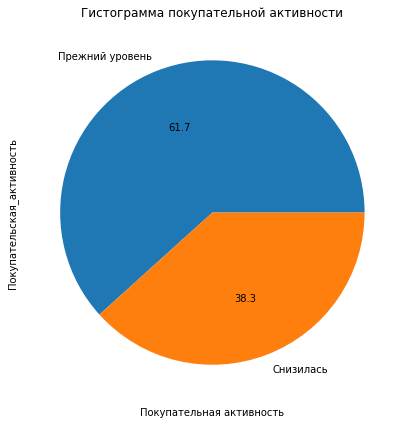

In [31]:
market_file['Покупательская_активность'].value_counts().plot(kind='pie', figsize=(7,7), autopct='%.1f')
plt.title('Гистограмма покупательной активности')
plt.xlabel('Покупательная активность');

По диаграмме можно сделать вывод, что активность большинства покупателей осталась на прежнем уровне: у 500 человек из 1300 покупательная активность снизилась, у остальных - осталась на прежнем уровне.

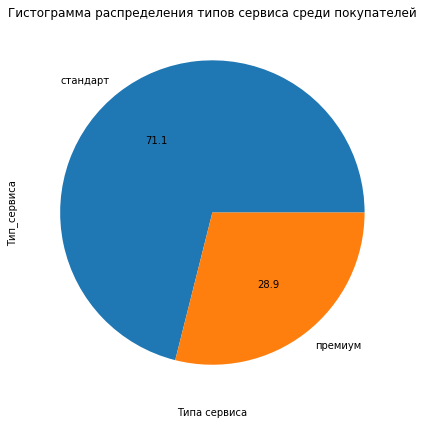

In [32]:
market_file['Тип_сервиса'].value_counts().plot(kind='pie', figsize=(7,7), autopct='%.1f')
plt.title('Гистограмма распределения типов сервиса среди покупателей')
plt.xlabel('Типа сервиса');

Анализируя распространение типов сервиса, можно заключить, что большей популярностью пользуется 'стандарт', его выбирает 71% покупателей.

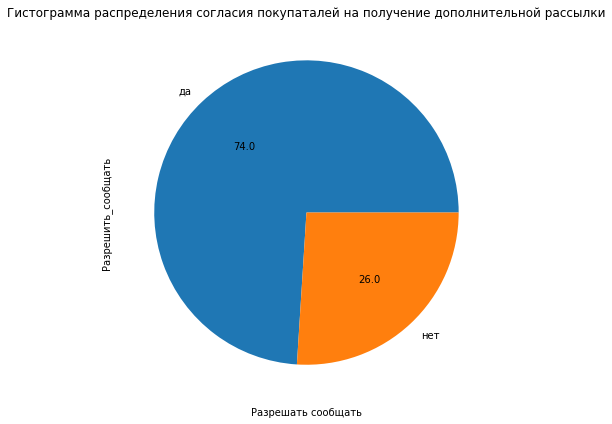

In [33]:
market_file['Разрешить_сообщать'].value_counts().plot(kind='pie', figsize=(7,7), autopct='%.1f')
plt.title('Гистограмма распределения согласия покупаталей на получение дополнительной рассылки')
plt.xlabel('Разрешать сообщать');

Большинство покупателей не против получать дополнительные сообщения с информацией о товаре.

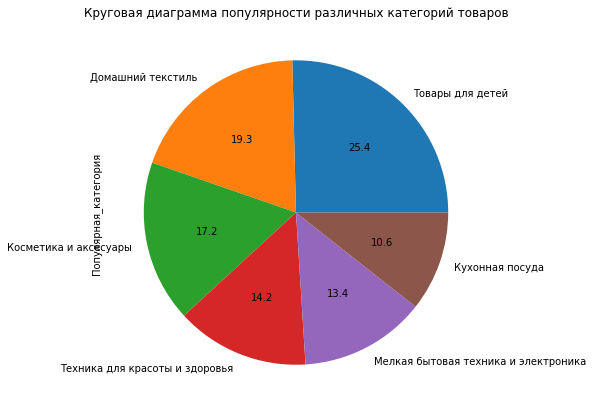

In [34]:
market_file['Популярная_категория'].value_counts().plot(kind='pie', figsize=(7,7), autopct='%.1f')
plt.title('Круговая диаграмма популярности различных категорий товаров');

Одной из самых популярных категорий товаров являются 'товары для детей' (25.4% всех покупок). Немного по популярности уступают 'домашний текстиль'(19.3%) и 'косметика и аксесуары' (17.2%). Наименее популярной категорией стала 'кухонная посуда' (10.6%)

Перейдём к анализу количественных признаков первой таблицы.

In [35]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [36]:
def stat(column):
    return column.median(), column.describe(), column.hist(bins=30), plt.title('Столбчатая гистограмма признака'), plt.xlabel('Признак'), plt.ylabel('Количество');

(4.2,
 count    1300.000000
 mean        4.253769
 std         1.014814
 min         0.900000
 25%         3.700000
 50%         4.200000
 75%         4.900000
 max         6.600000
 Name: Маркет_актив_6_мес, dtype: float64,
 <Axes: title={'center': 'Столбчатая гистограмма признака'}, xlabel='Признак', ylabel='Количество'>,
 Text(0.5, 1.0, 'Столбчатая гистограмма признака'),
 Text(0.5, 0, 'Признак'),
 Text(0, 0.5, 'Количество'))

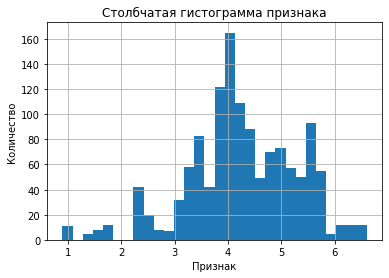

In [37]:
stat(market_file['Маркет_актив_6_мес'])

'Маркет_актив_6_мес' - это число рассылок, звонков, показов рекламы и прочего, которое приходилось на клиента за последние 6 месяцев. Среднее значение этого признака близко к значению медианы, что может быть косвенным свидетельством отсутствия экстремалных значений. Проверим это с помощью ящичковой диаграммы.

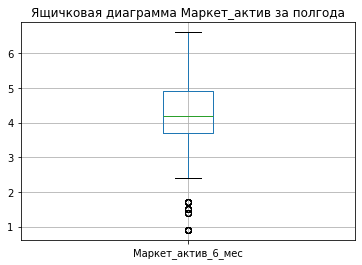

In [38]:
market_file.boxplot('Маркет_актив_6_мес')
plt.title('Ящичковая диаграмма Маркет_актив за полгода');

Оба графика показывают наличие низких значений рассылок, но я предлагаю эти данные не удалять, они не являются экстремальными.

(4.0,
 count    1300.000000
 mean        4.011538
 std         0.696868
 min         3.000000
 25%         4.000000
 50%         4.000000
 75%         4.000000
 max         5.000000
 Name: Маркет_актив_тек_мес, dtype: float64,
 <Axes: title={'center': 'Столбчатая гистограмма признака'}, xlabel='Признак', ylabel='Количество'>,
 Text(0.5, 1.0, 'Столбчатая гистограмма признака'),
 Text(0.5, 0, 'Признак'),
 Text(0, 0.5, 'Количество'))

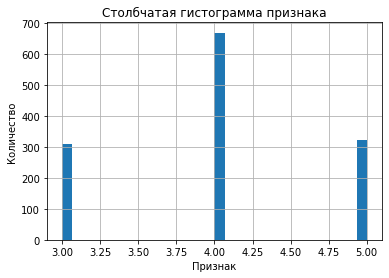

In [39]:
stat(market_file['Маркет_актив_тек_мес'])

Для признака 'Маркет_актив_тек_мес' среднее значение и медиана практически совпадают. Также по графику можно выделить три группы покупателей, получивших дополнительную информацию о товарах в текущем месяце.

(606.0,
 count    1300.000000
 mean      601.898462
 std       249.856289
 min       110.000000
 25%       405.500000
 50%       606.000000
 75%       806.000000
 max      1079.000000
 Name: Длительность, dtype: float64,
 <Axes: title={'center': 'Столбчатая гистограмма признака'}, xlabel='Признак', ylabel='Количество'>,
 Text(0.5, 1.0, 'Столбчатая гистограмма признака'),
 Text(0.5, 0, 'Признак'),
 Text(0, 0.5, 'Количество'))

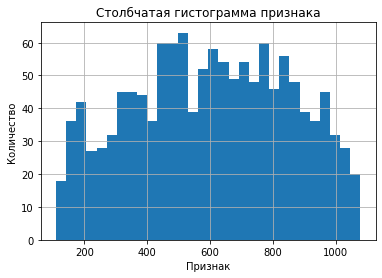

In [40]:
stat(market_file['Длительность'])

'Длительность' показывает, сколько дней прошло с момента регистрации покупателя на сайте. Значение медианы немного выше среднего значения, также довольно высокое стандартное отклонение. Построим столбчатую диаграмму.

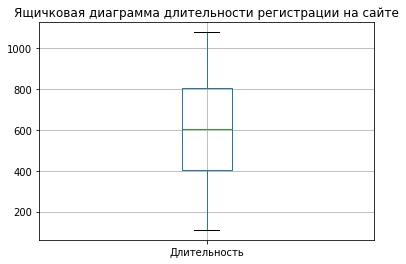

In [41]:
market_file.boxplot('Длительность')
plt.title('Ящичковая диаграмма длительности регистрации на сайте');

(0.24,
 count    1300.000000
 mean        0.319808
 std         0.249843
 min         0.000000
 25%         0.170000
 50%         0.240000
 75%         0.300000
 max         0.990000
 Name: Акционные_покупки, dtype: float64,
 <Axes: title={'center': 'Столбчатая гистограмма признака'}, xlabel='Признак', ylabel='Количество'>,
 Text(0.5, 1.0, 'Столбчатая гистограмма признака'),
 Text(0.5, 0, 'Признак'),
 Text(0, 0.5, 'Количество'))

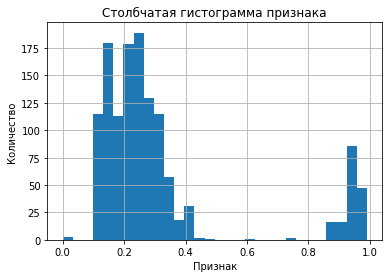

In [42]:
stat(market_file['Акционные_покупки'])

По значениям описательной статистики признака видно сильное отличие среднего и медианного значений. По графику гистограммы можно выделить две группы покупетелей: те, у кого доля акционных покупок составляет больше 0.5 и тех, у кого эта доля ментше 0.5

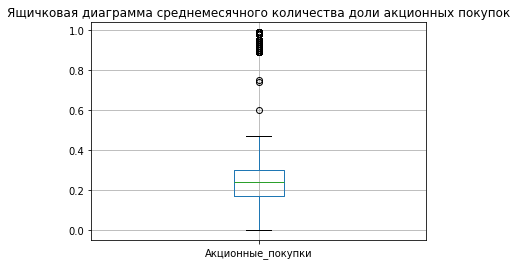

In [43]:
market_file.boxplot('Акционные_покупки')
plt.title('Ящичковая диаграмма среднемесячного количества доли акционных покупок');

In [44]:
market_file.loc[market_file['Акционные_покупки'] > 0.6]['Акционные_покупки'].count()

167

По графику ящичковой диаграммы мы видим целый ряд значений, которые превышают "усики". Но я предлагаю их не удалять, т.к. они не являются нереалистичными.

(3.0,
 count    1300.00000
 mean        3.27000
 std         1.35535
 min         1.00000
 25%         2.00000
 50%         3.00000
 75%         4.00000
 max         6.00000
 Name: Средний_просмотр_категорий_за_визит, dtype: float64,
 <Axes: title={'center': 'Столбчатая гистограмма признака'}, xlabel='Признак', ylabel='Количество'>,
 Text(0.5, 1.0, 'Столбчатая гистограмма признака'),
 Text(0.5, 0, 'Признак'),
 Text(0, 0.5, 'Количество'))

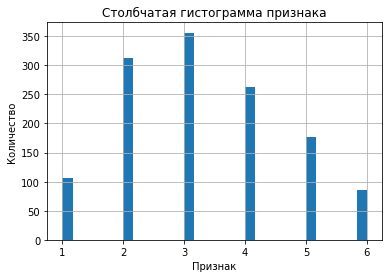

In [45]:
stat(market_file['Средний_просмотр_категорий_за_визит'])

По гистограмме признака можно сделать вывод, что в среднем за последний месяц покупатель за визит на сайт больше всего рассматривал до 2 до 4 категорий товаров.

In [46]:
(market_file.loc[(market_file['Средний_просмотр_категорий_за_визит'] >= 2) & (market_file['Средний_просмотр_категорий_за_визит'] < 5) ]['Средний_просмотр_категорий_за_визит'].count()/ market_file['Средний_просмотр_категорий_за_визит'].count())*100

71.61538461538461

Доля таких покупателей составляет 71.6%

(3.0,
 count    1300.000000
 mean        2.840000
 std         1.971451
 min         0.000000
 25%         1.000000
 50%         3.000000
 75%         4.000000
 max        10.000000
 Name: Неоплаченные_продукты_штук_квартал, dtype: float64,
 <Axes: title={'center': 'Столбчатая гистограмма признака'}, xlabel='Признак', ylabel='Количество'>,
 Text(0.5, 1.0, 'Столбчатая гистограмма признака'),
 Text(0.5, 0, 'Признак'),
 Text(0, 0.5, 'Количество'))

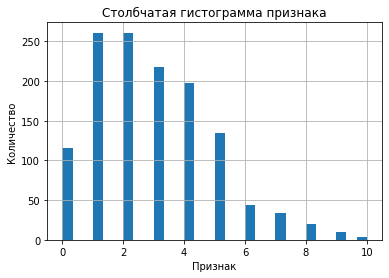

In [47]:
stat(market_file['Неоплаченные_продукты_штук_квартал'])

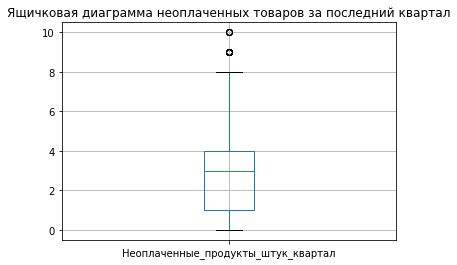

In [48]:
market_file.boxplot('Неоплаченные_продукты_штук_квартал')
plt.title('Ящичковая диаграмма неоплаченных товаров за последний квартал');

(4.0,
 count    1300.000000
 mean        4.185385
 std         1.955298
 min         0.000000
 25%         3.000000
 50%         4.000000
 75%         6.000000
 max         9.000000
 Name: Ошибка_сервиса, dtype: float64,
 <Axes: title={'center': 'Столбчатая гистограмма признака'}, xlabel='Признак', ylabel='Количество'>,
 Text(0.5, 1.0, 'Столбчатая гистограмма признака'),
 Text(0.5, 0, 'Признак'),
 Text(0, 0.5, 'Количество'))

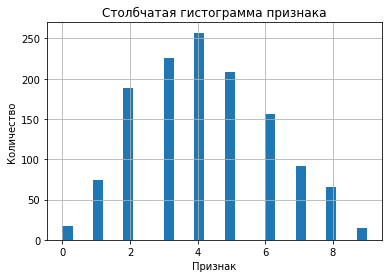

In [49]:
stat(market_file['Ошибка_сервиса'])

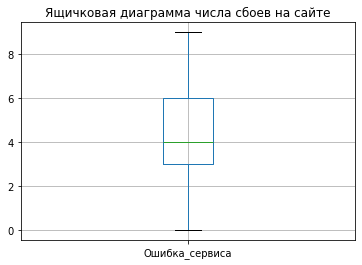

In [50]:
market_file.boxplot('Ошибка_сервиса')
plt.title('Ящичковая диаграмма числа сбоев на сайте');

(8.0,
 count    1300.000000
 mean        8.176923
 std         3.978126
 min         1.000000
 25%         5.000000
 50%         8.000000
 75%        11.000000
 max        20.000000
 Name: Страниц_за_визит, dtype: float64,
 <Axes: title={'center': 'Столбчатая гистограмма признака'}, xlabel='Признак', ylabel='Количество'>,
 Text(0.5, 1.0, 'Столбчатая гистограмма признака'),
 Text(0.5, 0, 'Признак'),
 Text(0, 0.5, 'Количество'))

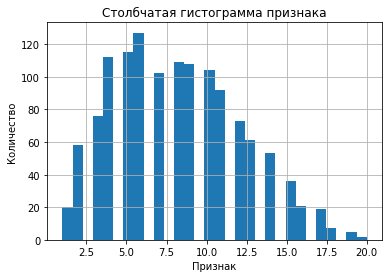

In [51]:
stat(market_file['Страниц_за_визит'])

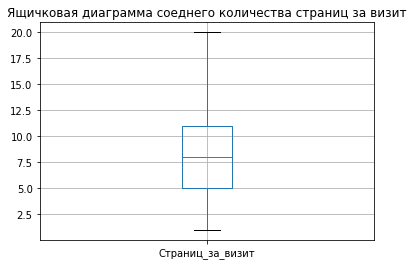

In [52]:
market_file.boxplot('Страниц_за_визит')
plt.title('Ящичковая диаграмма соеднего количества страниц за визит');

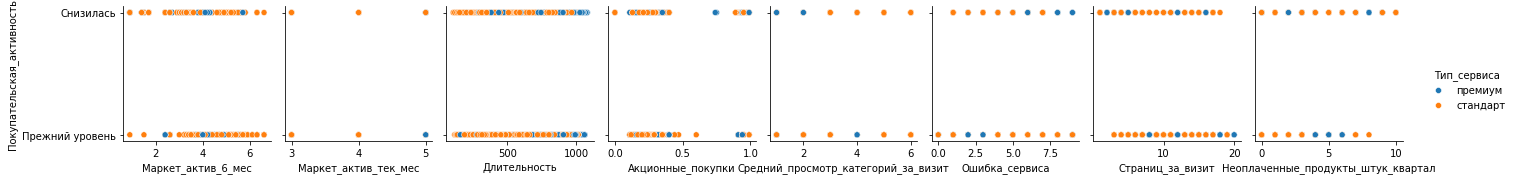

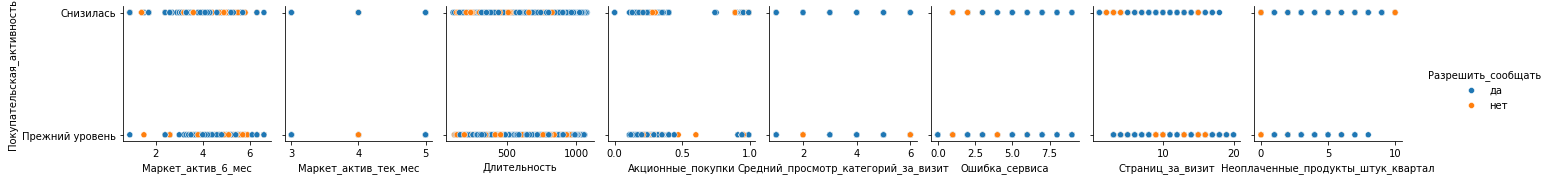

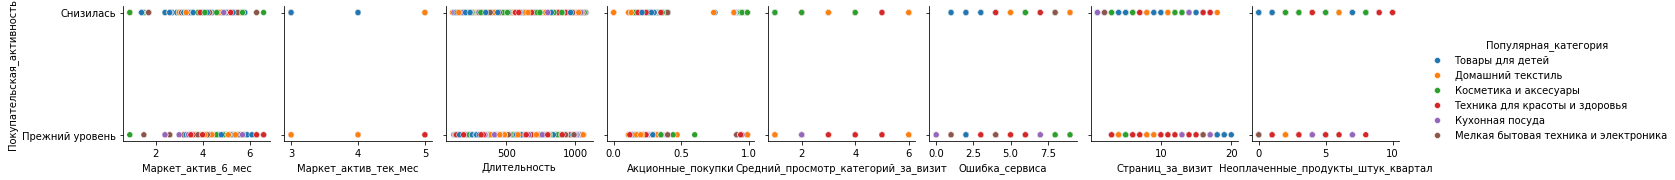

In [53]:
numeric_features = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Ошибка_сервиса', 'Страниц_за_визит', 'Неоплаченные_продукты_штук_квартал']
category_features = ['Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория']
for category in category_features:
    sns.pairplot(market_file, x_vars=numeric_features, y_vars='Покупательская_активность', hue=category)

Перейдём к исследованию данных второй таблицы.

(4957.5,
 count      3900.000000
 mean       5025.696051
 std        1777.704104
 min           0.000000
 25%        4590.150000
 50%        4957.500000
 75%        5363.000000
 max      106862.200000
 Name: Выручка, dtype: float64,
 <Axes: title={'center': 'Столбчатая гистограмма признака'}, xlabel='Признак', ylabel='Количество'>,
 Text(0.5, 1.0, 'Столбчатая гистограмма признака'),
 Text(0.5, 0, 'Признак'),
 Text(0, 0.5, 'Количество'))

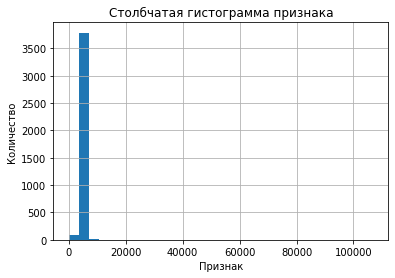

In [54]:
stat(market_money['Выручка'])

Среднее значение сильно превышает медианное, а также велико стандартное отклонение. Построим ящичковую диаграмму для этого признака.

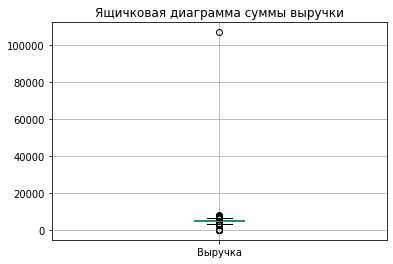

In [55]:
market_money.boxplot('Выручка')
plt.title('Ящичковая диаграмма суммы выручки');

Одно знаение очень сильно выбивается, рассмотрим его подробнее.

In [56]:
market_money.loc[market_money['Выручка'] > 50000]

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


Это значение является экстремальным значением, я предлагаю удалить эту цифру, чтобы она не искажала модель в дальнейшем, и заменить ее средним значением для этого покупателя.

In [57]:
market_money.loc[market_money['id'] == 215380]

,id,Период,Выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


In [58]:
market_money.loc[(market_money['id'] == 215380) & (market_money['Период'] != 'текущий_месяц')].mean()

id         215380.0
Выручка      5564.0
dtype: float64

In [59]:
market_money['Выручка'] = market_money['Выручка'].replace(106862.2, 5564.0)

In [60]:
market_money.loc[market_money['id'] == 215380]

,id,Период,Выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,5564.0


Повторим исследование описательной статистики для этого признака после внесения изменений.

(4957.5,
 count    3900.000000
 mean     4999.722154
 std       706.966984
 min         0.000000
 25%      4590.150000
 50%      4957.500000
 75%      5363.000000
 max      7799.400000
 Name: Выручка, dtype: float64,
 <Axes: title={'center': 'Столбчатая гистограмма признака'}, xlabel='Признак', ylabel='Количество'>,
 Text(0.5, 1.0, 'Столбчатая гистограмма признака'),
 Text(0.5, 0, 'Признак'),
 Text(0, 0.5, 'Количество'))

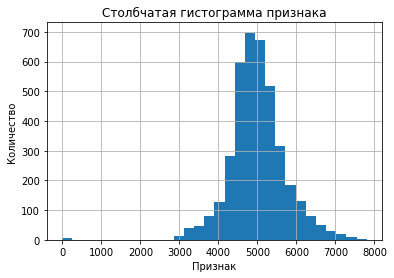

In [61]:
stat(market_money['Выручка'])

Сгруппируем данные по выручке по временному периоду и построим график.

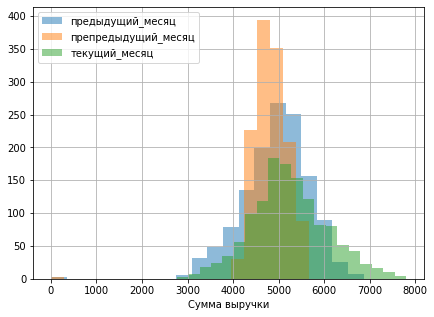

In [62]:
market_money.groupby('Период')['Выручка'].hist(bins=20, figsize=(7,5), legend='Период', alpha=0.5)
plt.xlabel('Сумма выручки');

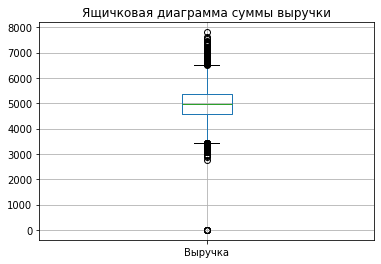

In [63]:
market_money.boxplot('Выручка')
plt.title('Ящичковая диаграмма суммы выручки');

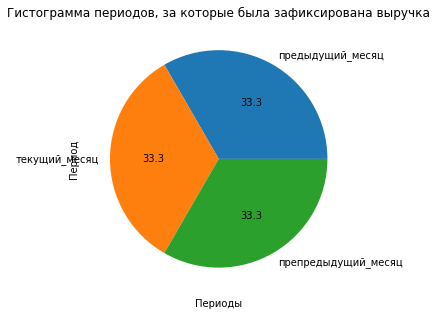

In [64]:
market_money['Период'].value_counts().plot(kind='pie', figsize=(5,5), autopct='%.1f')
plt.title('Гистограмма периодов, за которые была зафиксирована выручка')
plt.xlabel('Периоды');

За все месяцы было зафиксирвоано одинаковое количество пользователей, покупавших товары.

(13.0,
 count    2600.000000
 mean       13.336154
 std         4.080198
 min         4.000000
 25%        10.000000
 50%        13.000000
 75%        16.000000
 max        23.000000
 Name: минут, dtype: float64,
 <Axes: title={'center': 'Столбчатая гистограмма признака'}, xlabel='Признак', ylabel='Количество'>,
 Text(0.5, 1.0, 'Столбчатая гистограмма признака'),
 Text(0.5, 0, 'Признак'),
 Text(0, 0.5, 'Количество'))

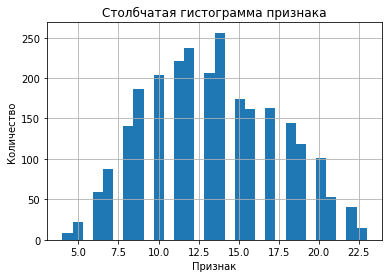

In [65]:
stat(market_time['минут'])

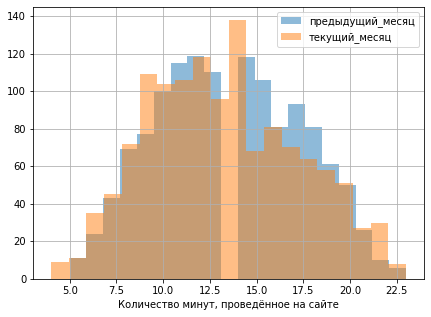

In [66]:
market_time.groupby('Период')['минут'].hist(bins=20, figsize=(7,5), legend='Период', alpha=0.5)
plt.xlabel('Количество минут, проведённое на сайте');

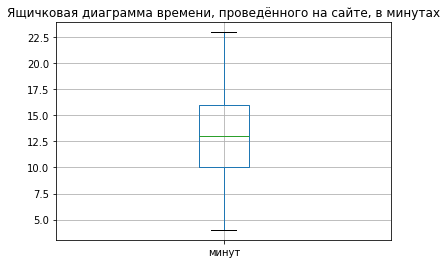

In [67]:
market_time.boxplot('минут')
plt.title('Ящичковая диаграмма времени, проведённого на сайте, в минутах');

По статистическим показателям выбросов и экстремальных значений в признаке "минут" нет.

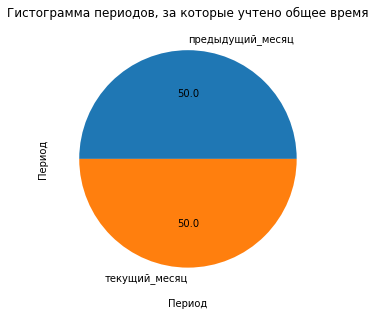

In [68]:
market_time['Период'].value_counts().plot(kind='pie', figsize=(5,5), autopct='%.1f')
plt.title('Гистограмма периодов, за которые учтено общее время')
plt.xlabel('Период');

Два наблюдаемых периода соответствуют друг другу по количеству покупателей.

(4.045,
 count    1300.000000
 mean        3.996631
 std         1.013722
 min         0.860000
 25%         3.300000
 50%         4.045000
 75%         4.670000
 max         7.430000
 Name: Прибыль, dtype: float64,
 <Axes: title={'center': 'Столбчатая гистограмма признака'}, xlabel='Признак', ylabel='Количество'>,
 Text(0.5, 1.0, 'Столбчатая гистограмма признака'),
 Text(0.5, 0, 'Признак'),
 Text(0, 0.5, 'Количество'))

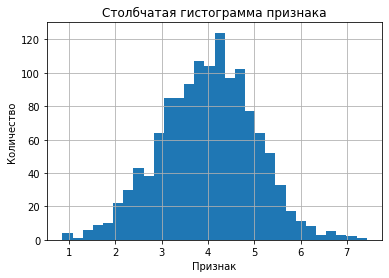

In [69]:
stat(money['Прибыль'])

Столбчатый график по признаку "Прибыль" очень напоминает график нормального распределения.

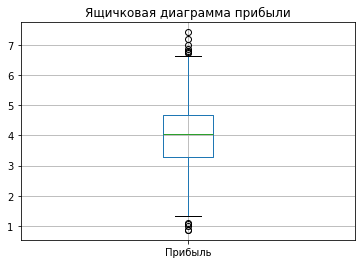

In [70]:
money.boxplot('Прибыль')
plt.title('Ящичковая диаграмма прибыли');

Нам необходимо отобрать клиентов с покупательной активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.

In [71]:
tempory_file = market_money.query('Выручка == 0')

In [72]:
tempory_file.head(10)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Мы обнаружили трёх клиентов, которые не были активны на протяжение трёх последних месяцев. Удалим их из всех таблиц для того, чтобы они не влияли на результаты дальнейших этапов анализа.

In [73]:
zeroes = [215348, 215357, 215359]

In [74]:
market_money_new = market_money[market_money.id.isin (zeroes) == False ]

In [75]:
market_money_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3891 entries, 3 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3891 non-null   int64  
 1   Период   3891 non-null   object 
 2   Выручка  3891 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 121.6+ KB


In [76]:
market_file_new = market_file[market_file.id.isin (zeroes) == False ]

In [77]:
market_time_new = market_time[market_time.id.isin (zeroes) == False ]

In [78]:
money_new = money[money.id.isin (zeroes) == False ]

**Вывод**

Мы провели исследовательский анализ данных. Нами было выявлено, что активность большинства покупателей осталась на прежнем уровне: у 500 человек из 1300 покупательная активность снизилась, у остальных - осталась на прежнем уровне.Анализируя распространение типов сервиса, можно заключить, что большей популярностью пользуется 'стандарт', его выбирает 71% покупателей.
Большинство покупателей не против получать дополнительные сообщения с информацией о товаре.
Одной из самых популярных категорий товаров являются 'товары для детей' (25.4% всех покупок). Немного по популярности уступают 'домашний текстиль'(19.3%) и 'косметика и аксесуары' (17.2%). Наименее популярной категорией стала 'кухонная посуда' (10.6%)
'Маркет_актив6мес' - это число рассылок, звонков, показов рекламы и прочего, которое приходилось на клиента за последние 6 месяцев. Среднее значение этого признака близко к значению медианы, что может быть косвенным свидетельством отсутствия экстремалных значений. 
Оба графика показывают наличие низких значений рассылок, но я предлагаю жти данные не удалять, они не являются экстремальными.
Для признака 'Маркет_актив_тек_мес' среднее значение и медиана практически совпадают. Также по графику можно выделить три группы покупателей, получивших дополнительную информацию о товарах в текущем месяце.
По графику гистограммы можно выделить две группы покупетелей: те, у кого доля акционных покупок составляет больше 0.5 и тех, у кого эта доля ментше 0.5
По графику ящичковой диаграммы среднемесячного количества доли акционных покупок мы видим целый ряд значений, которые превышают "усики". Но я предлагаю их не удалять, т.к. они не являются нереалистичными.По гистограмме признака можно сделать вывод, что в среднем за последний месяц покупатель за визит на сайт больше всего рассматривал до 2 до 4 категорий твоаров. Доля таких покупателей составляет 71.6%Удалили одно экстремальное значение по "выручке".

Также мы отобрали клиентов с покупательной активностью не менее трёх месяцев, исключив из анализа тех, кто хотя бы раз не делал покупки за этот трёхмесячный период.

## Шаг. Объединение таблиц

Объединим все таблицы последовательно, кроме money. Но сначала вынесем временные периоды в таблицах market_money и market_time в столбцы, чтобы сделать все таблицы равными между собой по количеству строк (1300 против 3900 и 2600 в исходных таблицах).

In [79]:
pivot_market_money = market_money_new.pivot(index='id', columns='Период', values='Выручка').reset_index()

In [80]:
pivot_market_money.head()

Период,id,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


Преобразуем таким же образом таблицу market_time_new.

In [81]:
pivot_market_time_ = market_time_new.pivot(index='id', columns='Период', values='минут')

In [82]:
data_1 = market_file_new.merge(pivot_market_money, on='id', how='left')

In [83]:
data_2 = data_1.merge(pivot_market_time_, on=['id'], how='left')

Проверим, адекватно ли выглядит итоговая таблица после слияния.

In [84]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская_активность            1297 non-null   object 
 2   Тип_сервиса                          1297 non-null   object 
 3   Разрешить_сообщать                   1297 non-null   object 
 4   Маркет_актив_6_мес                   1297 non-null   float64
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка_сервиса                

In [85]:
data_2.head(3)

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_x,препредыдущий_месяц,текущий_месяц_x,предыдущий_месяц_y,текущий_месяц_y
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13


In [86]:
data_2 = data_2.rename(columns = {'предыдущий_месяц_x':'Выручка_02_месяц', 'препредыдущий_месяц':'Выручка_03_месяц',
                              'текущий_месяц_x':'Выручка_01_месяц', 'предыдущий_месяц_y':'Минут_02_месяц',
                             'текущий_месяц_y':'Минут_01_месяц'})

In [87]:
data_2.head(3)

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_02_месяц,Выручка_03_месяц,Выручка_01_месяц,Минут_02_месяц,Минут_01_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13


In [88]:
data = data_2.set_index('id')

**Вывод**
Мы объединили все таблицы, которые понадобятся нам для дальнейшего моделирвоания, а также создали отдельный столбец по времени, проведённом на сайте, и выручке для каждого временного периода. Приступаем к корреляционному анализу!

##  Шаг. Корреляционный анализ

Изучим взаимосвязь между признаками, рассчитав между количественными признаками коэффициенты корреляции, воспользуемся библиотекой phix, методом phix_matrix.

In [89]:
data_1 = data.drop(['Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория'], axis=1)
data_1.phik_matrix()

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_02_месяц', 'Выручка_03_месяц', 'Выручка_01_месяц', 'Минут_02_месяц', 'Минут_01_месяц']


,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_02_месяц,Выручка_03_месяц,Выручка_01_месяц,Минут_02_месяц,Минут_01_месяц
Маркет_актив_6_мес,1.000000,0.080454,0.000000,0.278729,0.205783,0.286304,0.147270,0.394108,0.149129,0.312243,0.024850,0.363780,0.328385
Маркет_актив_тек_мес,0.080454,1.000000,0.174385,0.000000,0.246726,0.143827,0.116310,0.000000,0.054683,0.000000,0.000000,0.106879,0.062485
Длительность,0.000000,0.174385,1.000000,0.000000,0.187774,0.191923,0.174467,0.122727,0.125303,0.114058,0.147306,0.024075,0.100502
Акционные_покупки,0.278729,0.000000,0.000000,1.000000,0.199417,0.237583,0.000000,0.310741,0.065412,0.225681,0.072241,0.262189,0.250014
Средний_просмотр_категорий_за_визит,0.205783,0.246726,0.187774,0.199417,1.000000,0.325688,0.069908,0.262610,0.100332,0.176770,0.092944,0.159393,0.182708
Неоплаченные_продукты_штук_квартал,0.286304,0.143827,0.191923,0.237583,0.325688,1.000000,0.033392,0.363879,0.249471,0.261530,0.229691,0.255982,0.232121
Ошибка_сервиса,0.147270,0.116310,0.174467,0.000000,0.069908,0.033392,1.000000,0.182161,0.000000,0.140057,0.000000,0.244071,0.178471
Страниц_за_визит,0.394108,0.000000,0.122727,0.310741,0.262610,0.363879,0.182161,1.000000,0.145680,0.339672,0.139733,0.478787,0.382533
Выручка_02_месяц,0.149129,0.054683,0.125303,0.065412,0.100332,0.249471,0.000000,0.145680,1.000000,0.358036,0.835793,0.129355,0.195882
Выручка_03_месяц,0.312243,0.000000,0.114058,0.225681,0.176770,0.261530,0.140057,0.339672,0.358036,1.000000,0.410193,0.421143,0.342683


Попробуем изобразить эту таблицу с помощью тепловой карты для лучшего восприятия.

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_02_месяц', 'Выручка_03_месяц', 'Выручка_01_месяц', 'Минут_02_месяц', 'Минут_01_месяц']


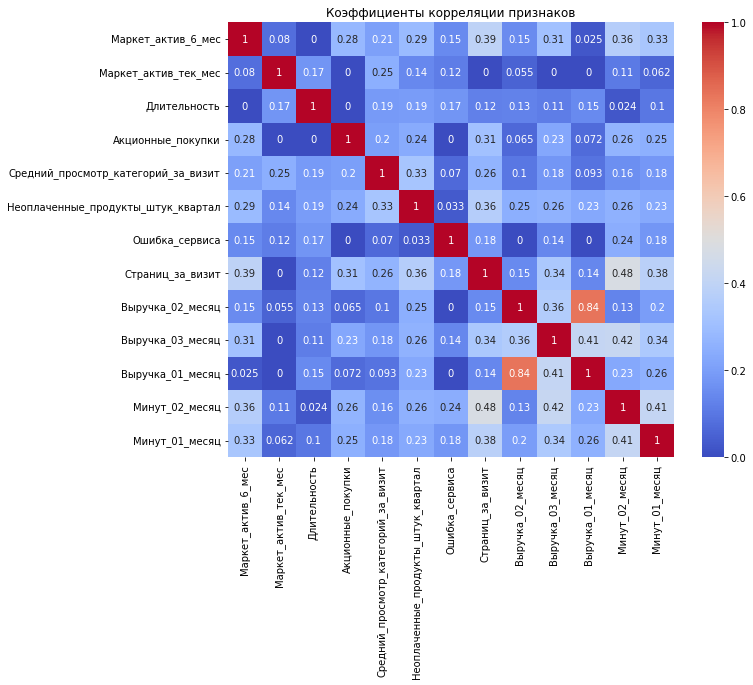

In [90]:
plt.figure(figsize=(10,8))
sns.heatmap(data_1.phik_matrix(), annot=True, cmap='coolwarm')
plt.title('Коэффициенты корреляции признаков')
plt.show();

Для трактовки силы связи между признаками будем использовать шкалу Чеддока. Таким образом, очень высокая линейная связь отмечается между выручкой в текущем месяце и выручкой в предыдущем месяце (коэффициент корреляции равен 0.84),что может свидетельствовать о мультиколлинеарности этих признаков. Пока мы принимаем решение не убирать один из этих признаков из таблицы, чтобы избавиться от мультиколлинеарности.
Умеренная связь выражена между признаками 'страниц_за_визит' и время, проведённое на саёте в предыдущем месяце (коэффициент коллеляции = 0.48), выручкой за препредыдущий месяц и временем, проведённом на сайте в предыдущий месяц (0.42), а также между признаками 'страниц_за_визит' и 'неоплаченные_продукты_штук_квартал' (0.36) и 'Маркет_актив_6_мес' (0.39).

**Вывод** 
Мы провели корреляционный анализ, в ходе которого выявили очень высокую линейную связь и предполагаемую мультиколлинеарность между выручкой за текущий и предыдущий месяц (коэффициент корреляции равен 0.84). Умеренная связь выражена между признаками 'страниц_за_визит' и время, проведённое на сайте в предыдущем месяце (коэффициент коллеляции = 0.48), выручкой за препредыдущий месяц и временем, проведённом на сайте в предыдущий месяц (0.42), а также между признаками 'страниц_за_визит' и 'неоплаченные_продукты_штук_квартал' (0.36) и 'Маркет_актив6мес' (0.39).

## Шаг. Использование пайплайнов

Подготовим данные для обучения модели, используя  ColumnTransformer. Количественные и категориальные признаки обработаем раздельно, для кодирования категориальных признаков используем OneHotEncoder и OrdinalEncoder, а для масштабирвоания количественных - StandardScaler и MinMaxScaler.
Создадим списки с названиями признаков и пайплайны для каждого кодирования и шага, а также общий пайплайн для подготовки данных. 
Но сначала для удобства закодируем знчаения признака 'Покупательская_активность' в числовой формат.

In [93]:
data['Покупательская_активность'].head(5)

id
215349    Снизилась
215350    Снизилась
215351    Снизилась
215352    Снизилась
215353    Снизилась
Name: Покупательская_активность, dtype: object

In [94]:
le = LabelEncoder()
le.fit(data['Покупательская_активность'])
le.classes_[1], le.classes_[0] = le.classes_[0], le.classes_[1]
data['Покупательская_активность'] = le.transform(data['Покупательская_активность'])

In [95]:
data['Покупательская_активность'].head()

id
215349    0
215350    0
215351    0
215352    0
215353    0
Name: Покупательская_активность, dtype: int64

In [96]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = data.drop(['Покупательская_активность'], axis=1)
y = data['Покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)


X_train.shape, X_test.shape

ohe_columns = [
    'Популярная_категория', 'Разрешить_сообщать'
]
ord_columns = [
    'Тип_сервиса'
]
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки',
               'Средний_просмотр_категорий_за_визит','Неоплаченные_продукты_штук_квартал',
               'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_01_месяц', 'Выручка_02_месяц',
               'Выручка_03_месяц', 'Минут_01_месяц', 'Минут_02_месяц']

ohe_pipe = Pipeline(
    [
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error',  sparse_output=False)
        )
    ]
)

ord_pipe = Pipeline(
    [
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['премиум', 'стандарт'],
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        )
    ]
)

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', MinMaxScaler(), num_columns)],
    remainder='passthrough'
)

Создадим итоговый пайплайн

In [97]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

 Обучим четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них попробуем подобрать как минимум один гиперпараметр. В качестве метрики будем использовать roc-auc, потому что она отображает истинную и постоянную способность модели к прогнозированию, устойчива к несбалансированным классам и может быть использована для сравнения различных моделей классификации.

In [98]:
param_distributions = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    {   'models': [SVC(random_state=RANDOM_STATE, probability=True)], 
        'models__kernel': ['poly', 'rbf', 'sigmoid'],
        'models__degree': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()] 
}
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Популярная_категория',
                                                   'Разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['премиум',
                                                                                               'стандарт']],
                                               

Командой grid_search.cv_results_ получим все результаты и сделаем из них датафрейм. Выведем четыре столбца, отсортируем по rank_test_score — рейтингу качества моделей:

In [99]:
result = pd.DataFrame(randomized_search.cv_results_)
print(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 

   rank_test_score                                       param_models  \
5                1  LogisticRegression(penalty='l1', random_state=...   
0                2  LogisticRegression(penalty='l1', random_state=...   
3                3  LogisticRegression(penalty='l1', random_state=...   
8                4            DecisionTreeClassifier(random_state=42)   
7                5             SVC(probability=True, random_state=42)   
1                6            DecisionTreeClassifier(random_state=42)   
9                7            DecisionTreeClassifier(random_state=42)   
6                8            DecisionTreeClassifier(random_state=42)   
2                9            DecisionTreeClassifier(random_state=42)   
4               10            DecisionTreeClassifier(random_state=42)   

   mean_test_score                                             params  
5         0.906989  {'preprocessor__num': StandardScaler(), 'model...  
0         0.906698  {'preprocessor__num': StandardSc

Получается, модель с наилучшими параметрами - KNeighborsClassifier(n_neighbors=14). Сохраним её.

In [100]:
y_proba = randomized_search.best_estimator_.predict_proba(X_test)[:, 0]

In [101]:
table = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

table.head()

,y_valid,y_proba
266,0,0.998608
202,0,0.998368
229,0,0.998301
200,0,0.997260
70,0,0.995686


**Вывод**
Мы подготовили данные для обучения модели, используя ColumnTransformer. Для удобства работы мы закодировали знчаения признака 'Покупательская_активность' в числовой формат. Количественные и категориальные признаки обработали раздельно, для кодирования категориальных признаков использовали OneHotEncoder и OrdinalEncoder, а для масштабирвоания количественных - StandardScaler и MinMaxScaler. Создали списки с названиями признаков и пайплайны для каждого кодирования и шага, а также общий пайплайн для подготовки данных. Мы обучили четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). Для каждой из них подобрали как минимум один гиперпараметр, в качестве метрики использовали roc-auc, которая отображаеть истинную и постоянную способность модели к прогнозированию.
Лучшей оказалась модель с наилучшими параметрами - KNeighborsClassifier(n_neighbors=14).

## Шаг. Анализ важности признаков

Оценим важность признаков для лучшей модели, которую мы получили в предыдущем шаге. Для этого сначала подготовим данные и используем графики метода SHAP. 
Для того, чтобы определить, какие признаки являются наиболее важными для прогнозов, выдаваемых моделью, используем столбчатую диаграмму (shap.plots.bar).

X_train_2 = pd.DataFrame(data_preprocessor.fit_transform(X_train), columns=data_preprocessor.get_feature_names_out() )
X_test_2 = pd.DataFrame(data_preprocessor.transform(X_test), columns=data_preprocessor.get_feature_names_out())

model = randomized_search.best_estimator_.named_steps['models']
model.fit(X_train_2.values, y_train)

explainer = shap.KernelExplainer(lambda x: model.predict_proba(x), shap.sample(X_train_2, 10))
shap_values = explainer(shap.sample(X_test_2, 10))
shap.plots.bar(shap_values[:, :, 0], max_display=21)

График помогает понять, какие признаки являются наиболее важными для работы нашей модели. Получается, самое большое среднее значение shap имеет признак "акционные покупки". Это значит, что этот признак оказывает наиболее сильное воздействие на прогнозы модели. На втором и третьем месте по "важности" - количество страниц за визит и количество времени, проведённое на сайте в текущем месяце. Наименее значимыми для модели получились признаки: выручка за текущий и предыдущий месяцы, ошибки сервиса, популярные категории (косметика и аксесуары) и неоплаченные продукты за квартал. 
При моделировании и принятии бизнес-решений можно использовать информацию, полученную при анализе важности признаков. Так, для более точного результата прогноза можно исключить из исследования наименее важные признаки, оставив наиболее ценные.

explainer = shap.KernelExplainer(lambda x: model.predict_proba(x), shap.sample(X_train_2))
shap_values = explainer.shap_values(shap.sample(X_test_2))
shap_obj = explainer(shap.sample(X_test_2))
shap.plots.beeswarm(shap_obj[:,:,1], max_display=21)

Исследуя SHAP‑значения на этой диаграмме, мы можем исследовать природу взаимоотношений между признаками и спрогнозированной покупательской активностью. Такие признаки, как количество страниц за визит, время, проведённое на сайте за текущий и прошлый месяц, средний просмотр категорий за визит растут по мере увеличения покупательской активности. Мы можем заметить и обратную ситуацию: чем больше значения признаков - тем меньше SHAP‑значения. Это наблюдение указывает на то, что более высокие значения 'неоплаченные продукты_шт_квартал', 'длительность' и 'выручка за текущий месяц' связаны с более низкой спрогнозированной покупательной активностью.

**Вывод**
Для анализа важности призанков мы использовали графики метода shap. Столбчатый график помогает понять, какие признаки являются наиболее важными для работы модели. Самое большое среднее значение shap имеет признак "акционные покупки", который оказывает наиболее сильное воздействие на прогнозы модели. На втором и третьем месте по "важности" - количество страниц за визит и количество времени, проведённое на сайте в текущем месяце. Наименее значимыми для модели получились признаки: выручка за текущий и предыдущий месяцы, ошибки сервиса, популярные категории (косметика и аксесуары) и неоплаченные продукты за квартал. При моделировании и принятии бизнес-решений можно использовать информацию, полученную при анализе важности признаков. Так, для более точного результата прогноза можно исключить из исследования наименее важные признаки, оставив наиболее ценные.

## Шаг. Сегментация покупателей

После получения прогнозов по вероятности снижения покупательской активности, рассмотрим покупаталей с точки зрения получаемой от них прибыли. Для этого построим диаграмму разброса.

In [102]:
probability = pd.DataFrame({'id': X_test.index, 'Вероятность_снижения': y_proba})

In [103]:
table_2 = probability.merge(money_new, on=['id'], how='left')

In [104]:
table_2.head(3)

,id,Вероятность_снижения,Прибыль
0,215905,0.269344,3.43
1,216146,0.515065,2.00
2,216104,0.034095,5.10


/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


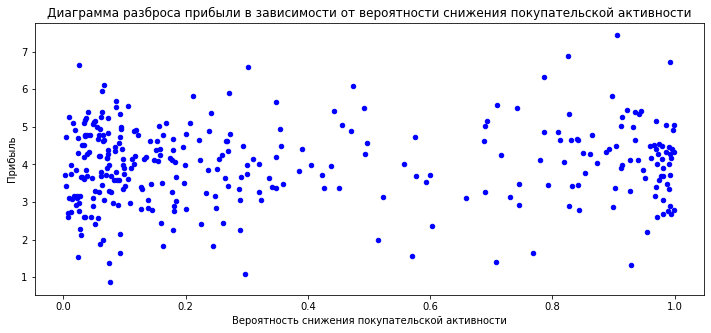

In [105]:
table_2.plot(kind='scatter', x='Вероятность_снижения', y='Прибыль',  figsize=(12,5), c='blue')
plt.title('Диаграмма разброса прибыли в зависимости от вероятности снижения покупательской активности')
plt.ticklabel_format(style='plain')
plt.xlabel('Вероятность снижения покупательской активности')
plt.ylabel('Прибыль');

Рассмотрим группу клиентов с наиболее высокой прибыльностью и высокой вероятностью снижения покупательской активности.

In [106]:
_f1 = table_2['Вероятность_снижения'] < 0.25
_f2 = table_2['Прибыль'] >= 3
low_activity = table_2[_f1 & _f2].sort_values(by='Вероятность_снижения', ascending=False)
low_activity.shape[0]

139

In [107]:
low_activity.head()

,id,Вероятность_снижения,Прибыль
71,215924,0.248378,3.16
178,216316,0.242373,5.37
95,216350,0.238591,4.89
140,215901,0.237065,3.85
258,216221,0.232648,3.23


Таких клиентов оказалось 156 человек.Рассмотрим, на какие категории товаров они тратят больше всего и меньше всего, как меняются их траты в течение трёх месяцев, проверим, по каким категориям товров траты проседают, а по каким наоборот увеличиваются. Добавим информацию об этом из нашей основной таблицы.

In [108]:
low_activity_view = low_activity.merge(data[['Популярная_категория','Выручка_01_месяц', 'Выручка_02_месяц', 'Выручка_03_месяц']], on=['id'], how='left')

In [109]:
low_activity_view.head()

,id,Вероятность_снижения,Прибыль,Популярная_категория,Выручка_01_месяц,Выручка_02_месяц,Выручка_03_месяц
0,215924,0.248378,3.16,Товары для детей,5538.2,5130.0,4809.0
1,216316,0.242373,5.37,Косметика и аксесуары,5197.2,5257.0,5476.0
2,216350,0.238591,4.89,Кухонная посуда,6076.6,5417.5,4807.0
3,215901,0.237065,3.85,Домашний текстиль,4353.8,4606.0,5047.0
4,216221,0.232648,3.23,Домашний текстиль,7314.0,5884.0,4384.0


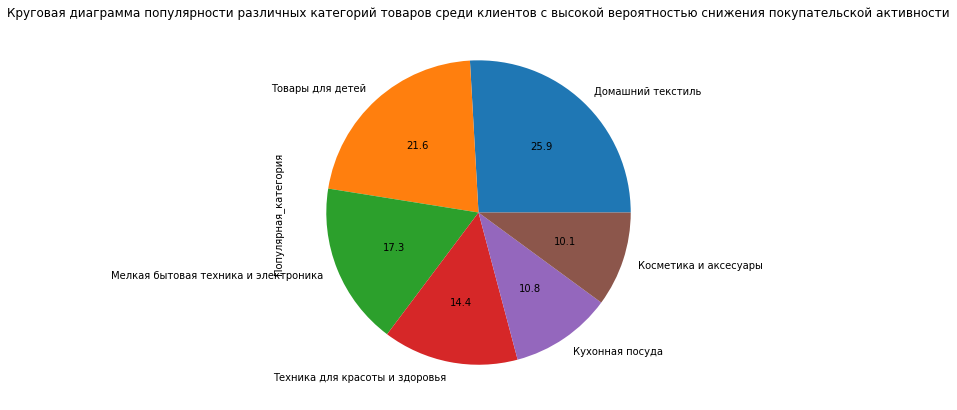

In [110]:
low_activity_view['Популярная_категория'].value_counts().plot(kind='pie', figsize=(7,7), autopct='%.1f')
plt.title('Круговая диаграмма популярности различных категорий товаров среди клиентов с высокой вероятностью снижения покупательской активности');

Наибольшей популярностью среди покупателей жтой группы пользовались такие категории товаров, как домашний текстиль, товары для детей и мелкая бытовая техника и электроника. Наименьшей популярностью пользовалась  косметика и аксесуары и кухонная посуда. Интересно посмотреь динамику покупок товаров этих категорий по времени.

Рассмотрим поведение группу покупаталей с высокой прибыльностью, но для которых наша модель предсказала другой результат: тех, чья покупательская активность осталась на прежнем уровне.

In [111]:
_f1 = table_2['Вероятность_снижения'] > 0.75
_f2 = table_2['Прибыль'] >= 3
high_activity = table_2[_f1 & _f2].sort_values(by='Вероятность_снижения', ascending=False)
high_activity.shape[0]

71

In [112]:
high_activity_view = high_activity.merge(data[['Популярная_категория','Выручка_01_месяц', 'Выручка_02_месяц', 'Выручка_03_месяц']], on=['id'], how='left')

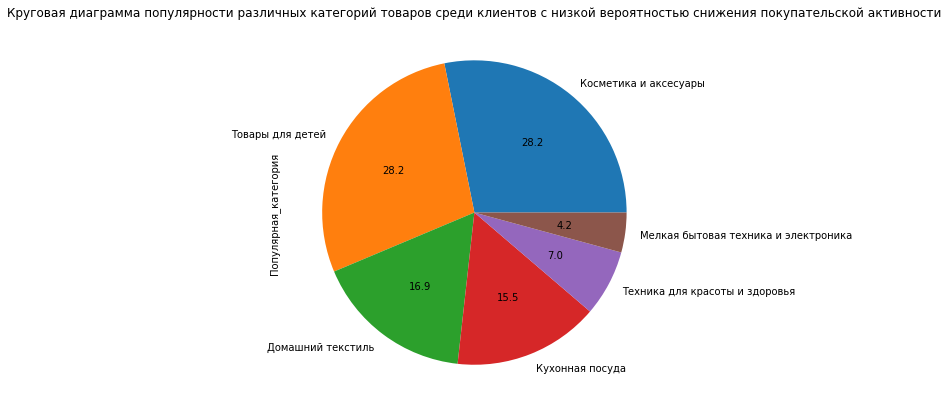

In [113]:
high_activity_view['Популярная_категория'].value_counts().plot(kind='pie', figsize=(7,7), autopct='%.1f')
plt.title('Круговая диаграмма популярности различных категорий товаров среди клиентов с низкой вероятностью снижения покупательской активности');

В этой группе покупателей почти в два раза меньше (72 против 156), и при этом популярными являются совсем другие категории товаров. Построим графики для выручси за текущий и предыдущий месяц в обеих рассматриваемых группах.

In [114]:
agg_func = {
    'Выручка_01_месяц': ['median'],
    'Выручка_02_месяц': ['median'],
    'Выручка_03_месяц': ['median']
}
low_activity_view.groupby('Популярная_категория').agg(agg_func).head(6)

,Выручка_01_месяц,Выручка_02_месяц,Выручка_03_месяц
,median,median,median
Популярная_категория,,,
Домашний текстиль,5201.80,4893.0,4906.5
Косметика и аксесуары,5099.15,4961.0,4928.0
Кухонная посуда,5563.00,5205.5,4870.0
Мелкая бытовая техника и электроника,5319.40,4989.5,4817.0
Техника для красоты и здоровья,5081.15,4962.0,5057.0
Товары для детей,5099.60,4889.5,5035.5


In [115]:
high_activity_view.groupby('Популярная_категория').agg(agg_func).head(6)

,Выручка_01_месяц,Выручка_02_месяц,Выручка_03_месяц
,median,median,median
Популярная_категория,,,
Домашний текстиль,5803.45,5310.75,4731.0
Косметика и аксесуары,5835.00,5446.00,4553.0
Кухонная посуда,5722.00,5215.00,4578.0
Мелкая бытовая техника и электроника,4445.40,4773.00,4500.0
Техника для красоты и здоровья,4547.60,4408.50,4426.0
Товары для детей,4990.20,4970.00,4578.0


Выделенная нами группа покупателей с высокой вероятностью снижения покупательной активности имеет лучшие показатели по прибыльности, чем группа спокупательской активностью на прежнем уровне. Для повышения покупательской активности рассматриваемой группы, мы рекомендуем ввести акции для популярных категорий товаров, таких, как домашний текстиль, товары для детей и мелкая бытовая техника и электроника.

**Вывод**
По результатам моделирования и после оценки важности признаков с помощью графиков shap, мы выяснили, что наиболее сильное воздействие на прогнозы модели оказывал признак "акционные покупки". Используя результаты моделирования и данные о прибыльности покупателей, мы для дальнейшего анализа выбрали группу клиентов с высокой прибыльностью и высокой вероятностью снижения покупательской активности. Мы исследовали, на какие категории товаров они тратят больше всего и меньше всего, изучили, как менялись траты в течение трёх месяцев и по каким категориям траты проседали, а по каким наоборот увеличивались. Мы сравнили изучаемую группу с контр-группой и в качестве рекомендаций для повышения покупательской активности мы предлагаем ввести акции на категории товаров, на которые они любят тратить больше всего (товары для детей, домашний текстиль), чтобы увеличить их покупательскую активность. Изучив разницу между покупками в разные месяцы, мы можем предложить ввести акции на категорию "техника дял красоты и здоровья", поскольку продажи в этой группе товаров почти не меняются. Возможно, это потому, что техника чаще покумается на долгий срок, а, возможно, потому, что на данную категорию требуются акции для увеличения покупательской активности.

## Шаг. Общий вывод.

Сделайте общий вывод:
опишите задачу;
опишите исходные данные и проведённую предобработку;
напишите, что вы сделали для поиска лучшей модели;
укажите лучшую модель;
добавьте выводы и дополнительные предложения для выбранного сегмента покупателей.

В нашу задачу входило изучить данные и по ним построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца, и, используя данные модели и данные о прибыльности клиентов, выделить сегменты покупателей и разработать для них персонализированные предложения.

Данные представляли собой четыре таблицы, в которых содержалась информация о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении, о выручке, которую получает магазин с покупателя,о времени, которое покупатель провёл на сайте в течение периода и о среднемесячной прибыли покупателя за последние 3 месяца. Мы изучили данные таблиц. В таблице 'market_file' и 'market_time' были внесены изменения в названия категорий столбцов и исправлены ошибки в названиях категорий. В таблицах полные дубликаты обнаружены не были, и во всех таблицах отсутствовали пропущенные значения

Мы провели исследовательский анализ данных. Было выявлено, что активность большинства покупателей осталась на прежнем уровне: у 500 человек из 1300 покупательная активность снизилась, у остальных - осталась на прежнем уровне.Анализируя распространение типов сервиса, мы заключили, что большей популярностью пользуется 'стандарт', его выбирает 71% покупателей. Большинство покупателей не против получать дополнительные сообщения с информацией о товаре. Одной из самых популярных категорий товаров являются 'товары для детей' (25.4% всех покупок). Немного по популярности уступают 'домашний текстиль'(19.3%) и 'косметика и аксесуары' (17.2%). Наименее популярной категорией стала 'кухонная посуда' (10.6%) 'Маркет_актив6мес' - это число рассылок, звонков, показов рекламы и прочего, которое приходилось на клиента за последние 6 месяцев. Среднее значение этого признака близко к значению медианы, что может быть косвенным свидетельством отсутствия экстремалных значений. Оба графика показывают наличие низких значений рассылок, но я предлагаю жти данные не удалять, они не являются экстремальными. Для признака 'Маркет_актив_тек_мес' среднее значение и медиана практически совпадают. Также по графику можно выделить три группы покупателей, получивших дополнительную информацию о товарах в текущем месяце. По графику гистограммы можно выделить две группы покупетелей: те, у кого доля акционных покупок составляет больше 0.5 и тех, у кого эта доля ментше 0.5 По графику ящичковой диаграммы среднемесячного количества доли акционных покупок мы видим целый ряд значений, которые превышают "усики". Но я предлагаю их не удалять, т.к. они не являются нереалистичными.По гистограмме признака можно сделать вывод, что в среднем за последний месяц покупатель за визит на сайт больше всего рассматривал до 2 до 4 категорий твоаров. Доля таких покупателей составляет 71.6%Удалили одно экстремальное значение по "выручке".

Также мы отобрали клиентов с покупательной активностью не менее трёх месяцев, исключив из анализа тех, кто хотя бы раз не делал покупки за этот трёхмесячный период.
В ходе корреляционного анализа мы выявили очень высокую линейную связь между выручкой за текущий и предыдущий месяц (коэффициент корреляции равен 0.84). Умеренная связь выражена между признаками 'страниц_за_визит' и время, проведённое на сайте в предыдущем месяце (коэффициент коллеляции = 0.48), выручкой за препредыдущий месяц и временем, проведённом на сайте в предыдущий месяц (0.42), а также между признаками 'страниц_за_визит' и 'неоплаченные_продукты_штук_квартал' (0.36) и 'Маркет_актив6мес' (0.39).

Далее мы подготовили данные для обучения модели, используя ColumnTransformer. Для удобства работы мы закодировали знчаения признака 'Покупательская_активность' в числовой формат. Количественные и категориальные признаки обработали раздельно, для кодирования категориальных признаков использовали OneHotEncoder и OrdinalEncoder, а для масштабирвоания количественных - StandardScaler и MinMaxScaler. Создали списки с названиями признаков и пайплайны для каждого кодирования и шага, а также общий пайплайн для подготовки данных. Мы обучили четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). Для каждой из них подобрали как минимум один гиперпараметр, в качестве метрики использовали roc-auc, которая отображаеть истинную и постоянную способность модели к прогнозированию. Лучшей оказалась модель с наилучшими параметрами - KNeighborsClassifier(n_neighbors=14).

Для анализа важности призанков мы использовали графики метода shap. Столбчатый график помогает понять, какие признаки являются наиболее важными для работы модели. Самое большое среднее значение shap имеет признак "акционные покупки", который оказывает наиболее сильное воздействие на прогнозы модели. На втором и третьем месте по "важности" - количество страниц за визит и количество времени, проведённое на сайте в текущем месяце. Наименее значимыми для модели получились признаки: выручка за текущий и предыдущий месяцы, ошибки сервиса, популярные категории (косметика и аксесуары) и неоплаченные продукты за квартал. При моделировании и принятии бизнес-решений можно использовать информацию, полученную при анализе важности признаков. Так, для более точного результата прогноза можно исключить из исследования наименее важные признаки, оставив наиболее ценные.

По результатам моделирования и после оценки важности признаков с помощью графиков shap, мы выяснили, что наиболее сильное воздействие на прогнозы модели оказывал признак "акционные покупки". Используя результаты моделирования и данные о прибыльности покупателей, мы для дальнейшего анализа выбрали группу клиентов с высокой прибыльностью и высокой вероятностью снижения покупательской активности. Мы исследовали, на какие категории товаров они тратят больше всего и меньше всего, изучили, как менялись траты в течение трёх месяцев и по каким категориям траты проседали, а по каким наоборот увеличивались. Мы сравнили изучаемую группу с контр-группой и в качестве рекомендаций для повышения покупательской активности мы предлагаем ввести акции на категории товаров, на которые они любят тратить больше всего (товары для детей, домашний текстиль), чтобы увеличить их покупательскую активность. Изучив разницу между покупками в разные месяцы, мы можем предложить ввести акции на категорию "техника дял красоты и здоровья", поскольку продажи в этой группе товаров почти не меняются. Возможно, это потому, что техника чаще покумается на долгий срок, а, возможно, потому, что на данную категорию требуются акции для увеличения покупательской активности.